![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Responsible AI - SageMaker Clarify</a>


[Amazon SageMaker Clarify](https://aws.amazon.com/sagemaker/clarify/) helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. 

In this notebook, we highlight how you can use SageMaker to train models, host them an inference endpoint, and provide bias detection and explainability to analyze data and understand prediction outcomes from the model.


__Dataset:__ 
The dataset we will use for this exercise is coming from [folktables](https://github.com/zykls/folktables). Folktables provide code to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).

__ML Problem:__ 
Ultimately, the goal will be to predict whether an individual's income is above \\$50,000. We will filter the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable substitute to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). The income threshold can be changed easily to define new prediction tasks.


1. <a href="#1">Read the dataset</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Feature Transformation</a>
    * <a href="#24">Train - Validation - Test Datasets</a>
    * <a href="#25">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Train (and Tune) a Classifier</a>
4. <a href="#4">Amazon SageMaker Clarify</a>

This notebook assumes availability of the SageMaker kernel `conda_pyhon3`. In addition, install folktables and sklearn:

In [1]:
!pip install -U -q scikit-learn==1.1.3
!pip install -U -q --no-deps folktables==0.0.11

In [2]:
# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Operational libraries
import sys
from io import StringIO
import os
import time
import sys
import IPython
from time import gmtime, strftime
from datetime import datetime, timedelta

sys.path.append("..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")


# SageMaker and connection libraries
import boto3
import urllib
import sagemaker
from sagemaker import get_execution_role
from sagemaker import Session
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker import clarify
from sagemaker import model_monitor
from datetime import date

today = date.today()
bucket = sagemaker.Session().default_bucket()
prfx = "sagemaker/sagemaker-clarify-income-model"
region = boto3.Session().region_name
client = boto3.client('sagemaker')

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

To read in the dataset, we will be using [folktables](https://github.com/zykls/folktables) which provides access to the US Census dataset. Folktables contains predefined prediction tasks but also allows the user to specify the problem type.

The US Census dataset distinguishes between household and individuals. To obtain data on individuals, we use `ACSDataSource` with `survey=person`. The feature names for the US Census data follow the same distinction and use `P` for `person` and `H` for `household`, e.g.: `AGEP` refers to age of an individual.

In [3]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grand parents living with granchildren
    "SCH",  # school enrollment
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

# Convert numpy array to dataframe
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# For further modelling we want to use only 2 groups (see DATAPREP notebook for details)
df = df[df["RAC1P"].isin([6, 8])].copy(deep=True)

## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [4]:
# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,SCH,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,1.0,0.0
27,23.0,2.0,21.0,5.0,2545.0,207.0,17.0,20.0,2.0,6.0,35.0,NaN,3.0,0.0
33,18.0,1.0,16.0,5.0,9610.0,6.0,17.0,8.0,2.0,6.0,33.0,NaN,2.0,0.0
46,40.0,1.0,15.0,3.0,4140.0,303.0,16.0,22.0,1.0,8.0,38.0,2.0,1.0,0.0
49,18.0,1.0,18.0,5.0,725.0,6.0,17.0,12.0,2.0,6.0,60.0,NaN,2.0,0.0


In [5]:
# Check how many rows and columns we have in the data frame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (55502, 14)


In [6]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  float64
 1   COW     55502 non-null  float64
 2   SCHL    55502 non-null  float64
 3   MAR     55502 non-null  float64
 4   OCCP    55502 non-null  float64
 5   POBP    55502 non-null  float64
 6   RELP    55502 non-null  float64
 7   WKHP    55502 non-null  float64
 8   SEX     55502 non-null  float64
 9   RAC1P   55502 non-null  float64
 10  PWGTP   55502 non-null  float64
 11  GCL     41987 non-null  float64
 12  SCH     55502 non-null  float64
 13  >50k    55502 non-null  float64
dtypes: float64(14)
memory usage: 6.4 MB


We can clearly see that all columns are numerical (`dtype = float64`). However, when checking the column headers (and information at top of the notebook), we should notice that we are actually dealing with multimodal data. We expect to see a mix of categorical, numerical and potentially even text information.

Let's cast the features accordingly. We start by creating list for each feature type.

In [7]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "GCL",
    "SCH",
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

sensitive_feature = ["RAC1P"]

In [8]:
# We cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# We cast categorical features to `category`
df[sensitive_feature] = df[sensitive_feature].astype("object")

# We cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

Let's check with `.info()` again to make sure the changes took effect.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  int64  
 1   COW     55502 non-null  object 
 2   SCHL    55502 non-null  object 
 3   MAR     55502 non-null  object 
 4   OCCP    55502 non-null  object 
 5   POBP    55502 non-null  object 
 6   RELP    55502 non-null  object 
 7   WKHP    55502 non-null  int64  
 8   SEX     55502 non-null  object 
 9   RAC1P   55502 non-null  object 
 10  PWGTP   55502 non-null  int64  
 11  GCL     41987 non-null  object 
 12  SCH     55502 non-null  object 
 13  >50k    55502 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 6.4+ MB


Looks good, so we can now separate model features from model target to explore them separately.

In [10]:
model_target = ">50k"
model_features = categorical_features + numerical_features + sensitive_feature

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'GCL', 'SCH', 'AGEP', 'WKHP', 'PWGTP', 'RAC1P']
Model target:  >50k


In [11]:
# Double check that that target is not accidentally part of the features
model_target in model_features

False

All good here. We made sure that the target is not in the feature list. If we find the above statement showing `True` we need to remove the target by calling `model_features.remove(model_target)`.

Let's have a look at missing values next.


#### Missing values
The quickest way to check for missing values is to use `.isna().sum()`. This will provide a count of how many missing values we have. In fact, we can also see the count of missing values with `.info()` as it provided a count of non-null values.

In [12]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      13515
SCH          0
>50k         0
dtype: int64

No missing values anywhere apart from GCL - we might need to drop this column.

#### Target distribution

Let's check our target distribution.

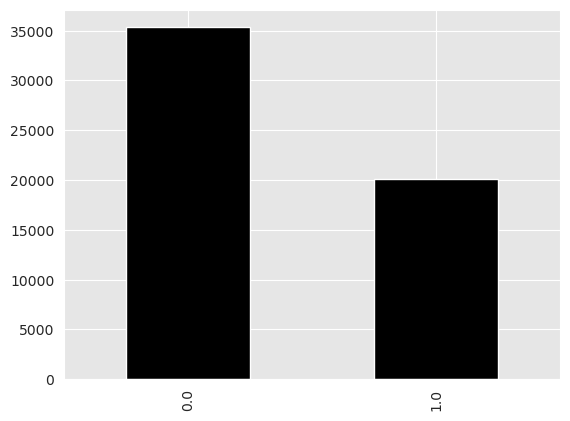

In [13]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

We notice that we are dealing with an imbalanced dataset. This means there are more examples for one type of results (here: 0; meaning individuals earning $\leq$ 50k). This is relevant for model choice and potential up-sampling or down-sampling to balance out the classes.

#### Feature distribution(s)

Let's now plot bar charts for the shortlist features of our dataset. We want to use Seaborns' `pairplot` as this will provide a lot of information about distribution and correlation of features.

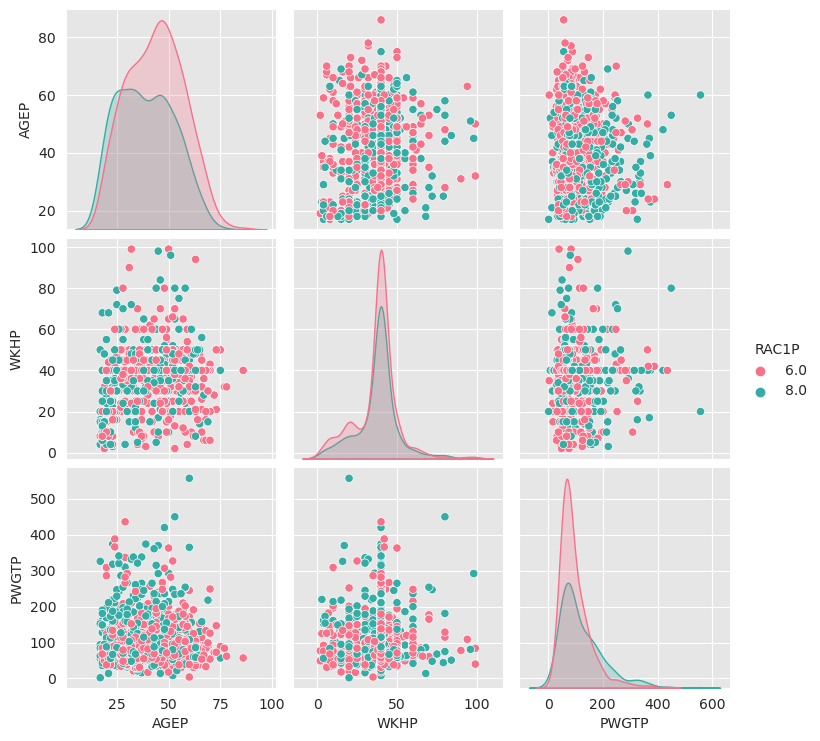

In [14]:
sns.pairplot(
    df[numerical_features + ["RAC1P"]].sample(1000),
    hue="RAC1P",
    palette=sns.color_palette("husl", 2),
)  # this will plot the numerical features and separate by sensitive attribute
plt.show()

### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

During the extended EDA in the DATAPREP notebook, we learned that `GCL` is a feature that is equally present for both outcome types and also contains a lot of missing values. Therefore, we can drop it from the list of features we want to use for model build. We also drop `OCCP` and `POBP` as those features have too many unique categories.

In [15]:
to_remove = ["GCL", "OCCP", "POBP"]

# Drop to_remove features from the respective list(s) - if applicable
for ft in to_remove:
    if ft in model_features:
        model_features.remove(ft)
    if ft in categorical_features:
        categorical_features.remove(ft)
    if ft in numerical_features:
        numerical_features.remove(ft)
    if ft in sensitive_feature:
        sensitive_feature.remove(ft)
        
# Let's also clean up the dataframe and only keep the features and columns we need
df = df[model_features + [model_target]].copy(deep=True)

### 2.3 <a name="23">Feature transformation</a>
(<a href="#2">Go to Data Processing</a>)

In this notebook, we won't perform any transformation.

### 2.4 <a name="24">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

To get a training, test and validation set, we will use sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Before splitting the data, we need to correctly cast categorical and numerical values again. The transformation leads to casting everything as numerical values. We can simply copy the same code we were using in the beginning (make sure to update the dataframe name).

In [16]:
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=23
)

train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation datasets shapes:  (42458, 11) (5551, 11) (7493, 11)


### 2.5 <a name="25">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

Let's build a full model pipeline. We need pre-processing split per data type, and then combine everything back into a composite pipeline. To achieve this, we will use sklearns `Pipeline` and `ColumnTransformer`.

__Step 1 (set up pre-processing per data type):__
> For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's `SimpleImputer`, followed by a `MinMaxScaler` (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.

 > In the categorical features pipeline, the __categorical_processor__ below, we impute with a placeholder value and encode with sklearn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
 
__Step 2 (combining pre-processing methods into a transformer):__ 
 > The selective preparations of the dataset features are then put together into a collective `ColumnTransformer`, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.
   

In [17]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        (
            "cat_encoder",
            OneHotEncoder(sparse=False, drop="if_binary", handle_unknown="ignore"),
        ),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)

In [18]:
# Let's take a smaller sample of all datasets to speed up the next steps
train_data = train_data.sample(frac=0.2, random_state=1)
val_data = val_data.sample(frac=0.2, random_state=1)
test_data = test_data.sample(frac=0.2, random_state=1)

We learn and apply the transformation. This will create new dataframes that have many more columns (due to the one hot encoding) and will contain normalized numerical features. Careful with the usage of transformation for models that are deployed (rather than single use); we will need a transformation job that can convert incoming data into the same shape as we used to train the model.

In [19]:
transf_train = data_processor.fit_transform(train_data)
transf_val = data_processor.transform(val_data)
transf_test = data_processor.transform(test_data)

In [20]:
# Get the column names for categorical features
cat_ft_names = list(
    data_processor.transformers_[1][1]
    .named_steps["cat_encoder"]
    .get_feature_names(categorical_features)
)

Now that we have the different data splits, let's upload them to S3. Clarify requires all data to be stored in S3 and we will also need to use an in-built SageMaker model.

In [21]:
# Assign file names
train_file, val_file, test_file, = (
    "train.csv",
    "val.csv",
    "test.csv",
)

# Create dataframes (preprocessed data)
raw_train = pd.DataFrame(transf_train)
raw_val = pd.DataFrame(transf_val)
raw_test = pd.DataFrame(transf_test)

# Convert

# Join with model target and sensitive column and save to CSV
pd.concat(
    [
        train_data[model_target].astype(int).reset_index(drop=True),
        train_data[sensitive_feature].astype(object).reset_index(drop=True),
        raw_train,
    ],
    axis=1,
).to_csv(train_file, index=False, header=False, sep=",")

# Repeat for validation data
pd.concat(
    [
        val_data[model_target].astype(int).reset_index(drop=True),
        val_data[sensitive_feature].astype(object).reset_index(drop=True),
        raw_val,
    ],
    axis=1,
).to_csv(val_file, index=False, header=False, sep=",")

# Repeat for test data
pd.concat(
    [
        test_data[model_target].astype(int).reset_index(drop=True),
        test_data[sensitive_feature].astype(object).reset_index(drop=True),
        raw_test,
    ],
    axis=1,
).to_csv(test_file, index=False, header=False, sep=",")

In [22]:
# Check that all sets have same number of columns
raw_train.shape, raw_test.shape, raw_val.shape

((8492, 62), (1110, 62), (1499, 62))

### 2.5 <a name="25">Upload Data</a>
(<a href="#2">Go to Data Processing</a>)

Here upload the data to S3.

In [23]:
train_uri = S3Uploader.upload(train_file, "s3://{}/{}/data/train".format(bucket, prfx))
val_uri = S3Uploader.upload(val_file, "s3://{}/{}/data/train".format(bucket, prfx))
test_uri = S3Uploader.upload(test_file, "s3://{}/{}/data/test".format(bucket, prfx))

In [24]:
# Delete the CSVs from the local instance
os.remove(test_file)
os.remove(train_file)
os.remove(val_file)

## 3. <a name="3">Train a Classifier</a>
(<a href="#0">Go to top</a>)


### Set up XGBoost Estimator

Next, let us set up an XGBoost estimator from the Sklearn pre-built models.

    

In [25]:
# Set an output path where the trained model will be saved
output_path = "s3://{}/{}/output".format(bucket, prfx)

# Set required XGboost hyperparameters
hyperparams = {
    "max_depth": "5",
    "subsample": "0.7",
    "verbosity": "1",
    "objective": "binary:logistic",
    "num_round": "10",
}

# Create a container with XGBoost
container = sagemaker.image_uris.retrieve("xgboost", region, "latest")

# Specify name for training job
job_name = "clarify-model-xgb-training"

# Call the XGBoost estimator object
XGBoost_estimator = sagemaker.estimator.Estimator(
    container,
    get_execution_role(),
    hyperparameters=hyperparams,
    disable_profiler=True,
    instance_count=1,
    base_job_name=job_name,
    instance_type="ml.m5.2xlarge",
    output_path=output_path,
    sagemaker_session=sagemaker.Session(),
)

Specify the inputs for the model and fit.

In [26]:
# Specify the training data
train_input = TrainingInput(train_uri, content_type="csv")

# Specify the validation data - not necessary, but can be used if tuning desired
validation_input = TrainingInput(val_uri, content_type="csv")

XGBoost_estimator.fit(
    {"train": train_input}, logs=False
)  # if desired "validation": validation_input

INFO:sagemaker:Creating training-job with name: clarify-model-xgb-training-2023-04-25-23-18-27-750



2023-04-25 23:18:28 Starting - Starting the training job..
2023-04-25 23:18:44 Starting - Preparing the instances for training.......
2023-04-25 23:19:24 Downloading - Downloading input data....
2023-04-25 23:19:49 Training - Downloading the training image...
2023-04-25 23:20:09 Training - Training image download completed. Training in progress.....
2023-04-25 23:20:34 Uploading - Uploading generated training model.
2023-04-25 23:20:46 Completed - Training job completed


We are almost ready to deploy the model. One final setting we want to specify is `DataCaptureConfig`. This setting will allow us later to check if the data that is submitted to the model endpoint follows a similar distribution as the data that was used for training.

In [27]:
s3_capture_upload_path = "s3://{}/{}/datacapture".format(bucket, prfx)

data_capture_config = model_monitor.DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
)

In [28]:
endpointname = "clarify-model-xgb-%s" % today.strftime("%Y%m%d%h")
modelname = "clarify-model-xgb"

XGBoost_predictor = XGBoost_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=CSVSerializer(),
    endpoint_name=endpointname,
    model_name=modelname,
    data_capture_config=data_capture_config,
)  # endpoint_name needs to be unique! Use AWS account number as part of name, or at least timestamp

INFO:sagemaker:Creating model with name: clarify-model-xgb
INFO:sagemaker:Creating endpoint-config with name clarify-model-xgb-20230425Apr
INFO:sagemaker:Creating endpoint with name clarify-model-xgb-20230425Apr


----------!

In [29]:
# Check that endpoint works by getting some predictions of the test data
XGBoost_predictor.predict(raw_test.to_numpy()[:20, :])

b'0.20109091699123383,0.1581142097711563,0.13745033740997314,0.10564066469669342,0.1926421970129013,0.1260198950767517,0.05225953087210655,0.24344408512115479,0.08050476759672165,0.1260198950767517,0.18747873604297638,0.14705978333950043,0.1926421970129013,0.1325863152742386,0.1926421970129013,0.09346900880336761,0.2527164816856384,0.1926421970129013,0.08050476759672165,0.41217148303985596'

Finally, create a model in SageMaker (optional). This can be helpful if you want to see the model in the AWS console. Another option at this point is to compile the model (optimize for performance). 

In [30]:
model = XGBoost_estimator.create_model()

## 4. <a name="4">Amazon SageMaker Clarify</a>
(<a href="#0">Go to top</a>)

Now that you have your model set up, let's say hello to SageMaker Clarify!

In [31]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=Session(),
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


A ModelConfig object communicates information about your trained model. To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. 
The parameters `instance_type` and `instance_count` specify your preferred instance type and instance count used to run your model on during SageMaker Clarify’s processing.

In [32]:
model_config = clarify.ModelConfig(
    model_name=modelname,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

A `ModelPredictedLabelConfig` provides information on the format of your predictions. XGBoost classifier produces output probabilities of samples, so SageMaker Clarify invokes the endpoint then uses `probability_threshold` to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value 1 and below or equal as label value 0.

In [33]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.6)

### 4.1. <a name="4.1.">Bias Reporting</a>
(<a href="#0">Go to top</a>)

A `DataConfig` object communicates some basic information about data to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (label), the header names, and the dataset type.

In [34]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prfx)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label=model_target,
    headers=[model_target] + sensitive_feature + numerical_features + cat_ft_names,
    dataset_type="text/csv",
)

SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are `label_values_or_threshold`. Here `facet_name = RAC1P` and we want to look for bias against group 6. The desired outcome is with earnings $\geq$ 50k. If you wanted to include another facet to analyze, provide a list; e.g., `facet_name = ["RAC1P", "AGEP"]`. Have a look at the documentation [here](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html).

In [40]:
# Set up bias config
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name="RAC1P",
    facet_values_or_threshold=[6],
)

We are ready to run the bias report. This type of report expects a trained model. There is also the option to evaluate for pre-training bias using:
```
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods=["CI", "DPL"],
)
```
The pre-training bias can be evaluated as soon as the data is uploaded to S3.

In [41]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['>50k', 'RAC1P', 'AGEP', 'WKHP', 'PWGTP', 'COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 'SEX_2.0', 'SCH_1.0', 'SCH_2.0', 'SCH_3.0'], 'label': '>50k', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'RAC1P', 'value_or_threshold': [6]}], 'methods': {'report': {'name': 'report', 'tit

.......................................2023-04-26 02:34:13,823 logging.conf not found when configuring logging, using default logging configuration.
2023-04-26 02:34:13,824 Starting SageMaker Clarify Processing job
2023-04-26 02:34:13,825 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-04-26 02:34:13,825 Analysis result path: /opt/ml/processing/output
2023-04-26 02:34:13,827 This host is algo-1.
2023-04-26 02:34:13,827 This host is the leader.
2023-04-26 02:34:13,827 Number of hosts in the cluster is 1.
2023-04-26 02:34:14,093 Running Python / Pandas based analyzer.
2023-04-26 02:34:14,093 Dataset type: text/csv uri: /opt/ml/processing/input/data
2023-04-26 02:34:14,104 Loading dataset...
/usr/local/lib/python3.9/site-packages/analyzer/data_loading/csv_data_loader.py:330: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
2023-04-

02:37:27.371 [Thread-4] WARN  o.a.spark.sql.catalyst.util.package - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
02:37:28.949 [dispatcher-event-loop-2] WARN  o.a.spark.scheduler.TaskSetManager - Stage 0 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.
02:37:30.902 [dispatcher-event-loop-3] WARN  o.a.spark.scheduler.TaskSetManager - Stage 3 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.
02:37:31.733 [dispatcher-event-loop-1] WARN  o.a.spark.scheduler.TaskSetManager - Stage 9 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.
02:37:32.046 [dispatcher-event-loop-0] WARN  o.a.spark.scheduler.TaskSetManager - Stage 12 contains a task of very large size (1152 KiB). The maximum recommended task size is 1000 KiB.
02:37:32.462 [dispatcher-event-loop-3] WARN  o.

### 4.2. <a name="4.2.">Explainability Reporting</a>
(<a href="#0">Go to top</a>)

Let's move on to explainability concepts. We start with a test value and baseline.

In [60]:
baseline = (
    pd.concat(
        [
            test_data[sensitive_feature].astype(object).reset_index(drop=True),
            raw_test,
        ],
        axis=1,
    )
    .iloc[0]
    .values.tolist()
)

Similar to the bias report, we first need to provide some specifications.

In [61]:
# Set up path for where explainability output should be stored
explainability_report_output_path = "s3://{}/{}/clarify-explainability".format(
    bucket, prfx
)

# Initialize configuration for SHAP
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

# Provide details about the data used for the explainability example
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_report_output_path,
    label=model_target,
    headers=[model_target] + sensitive_feature + numerical_features + cat_ft_names,
    dataset_type="text/csv",
)

Now we can run the explainability report.

In [62]:
# Run the explainability job
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['>50k', 'RAC1P', 'AGEP', 'WKHP', 'PWGTP', 'COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 'SEX_2.0', 'SCH_1.0', 'SCH_2.0', 'SCH_3.0'], 'label': '>50k', 'predictor': {'model_name': 'clarify-model-xgb', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'conten

.......................................2023-04-26 05:23:39,369 logging.conf not found when configuring logging, using default logging configuration.
2023-04-26 05:23:39,370 Starting SageMaker Clarify Processing job
2023-04-26 05:23:39,371 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-04-26 05:23:39,371 Analysis result path: /opt/ml/processing/output
2023-04-26 05:23:39,372 This host is algo-1.
2023-04-26 05:23:39,372 This host is the leader.
2023-04-26 05:23:39,372 Number of hosts in the cluster is 1.
2023-04-26 05:23:39,643 Running Python / Pandas based analyzer.
2023-04-26 05:23:39,644 Dataset type: text/csv uri: /opt/ml/processing/input/data
2023-04-26 05:23:39,657 Loading dataset...
/usr/local/lib/python3.9/site-packages/analyzer/data_loading/csv_data_loader.py:330: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
2023-04-

In [64]:
# Specify path to save explanations
local_explanations_out = pd.read_csv(
    explainability_report_output_path + "/explanations_shap/out.csv"
)

# Extract and update feature names
feature_names = [
    str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()
]
local_explanations_out.columns = feature_names

# Show selected example
selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", raw_train.iloc[selected_example])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Example number: 111 
with model prediction: False

Feature values -- Label 0     0.207792
1     0.397959
2     0.120253
3     1.000000
4     0.000000
        ...   
57    0.000000
58    0.000000
59    1.000000
60    0.000000
61    0.000000
Name: 111, Length: 62, dtype: float64


## 5. <a name="5">Amazon Model Monitor</a>
(<a href="#0">Go to top</a>)

A lot of the steps we took above, can immediately be used to set up monitoring too. With the existing model and data configuration we can set up a baseline job for example.

In [65]:
model_bias_monitor = model_monitor.ModelBiasMonitor(
    role=get_execution_role(),
    sagemaker_session=Session(),
    max_runtime_in_seconds=1800,
    base_job_name="bias-model-monitoring"
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


The method `suggest_baseline` suggests a set of baseline constraints and generate descriptive statistics that characterize the data in a training dataset stored in Amazon S3. It starts a Processing Job using a Model Monitor container provided by Amazon SageMaker to generate the constraints.

In [66]:
model_bias_monitor.suggest_baseline(
    model_config=model_config,
    data_config=bias_data_config,
    bias_config=bias_config,
    model_predicted_label_config=predictions_config,
)

print(
    f"ModelBiasMonitor baselining job: {model_bias_monitor.latest_baselining_job_name}"
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['>50k', 'RAC1P', 'AGEP', 'WKHP', 'PWGTP', 'COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 'SEX_2.0', 'SCH_1.0', 'SCH_2.0', 'SCH_3.0'], '

ModelBiasMonitor baselining job: bias-model-monitoring-2023-04-26-05-29-53-341


Besides captures, model bias monitoring execution also requires ground truth data. In real use cases, ground truth data should be regularly collected and uploaded to designated S3 location. In this example notebook, we assume that the train data is acting as ground truth.

In [67]:
ground_truth_data = train_uri

Now that you have a baseline and ground truth data, you can call the `create_monitoring_schedule()` method to schedule an hourly monitor to analyze the data with a monitoring schedule. 

In [68]:
# Set up path for where monitor output should be stored
model_monitor_output_path = "s3://{}/{}/clarify-monitor".format(
    bucket, prfx
)

model_bias_analysis_config = None
if not model_bias_monitor.latest_baselining_job:
    model_bias_analysis_config = model_monitor.BiasAnalysisConfig(
        bias_data_config,
        label=model_target,
        headers=[model_target] + sensitive_feature + numerical_features + cat_ft_names,
    )

model_bias_monitor.create_monitoring_schedule(
    analysis_config=model_bias_analysis_config,
    output_s3_uri=model_monitor_output_path,
    ground_truth_input=ground_truth_data, 
    endpoint_input=endpointname,
    schedule_cron_expression=model_monitor.CronExpressionGenerator.hourly(),
)
print(f"Model bias monitoring schedule: {model_bias_monitor.monitoring_schedule_name}")

INFO:sagemaker.model_monitor.clarify_model_monitoring:Uploading analysis config to {s3_uri}.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: bias-model-monitoring-2023-04-26-05-29-57-232


Model bias monitoring schedule: bias-model-monitoring-2023-04-26-05-29-57-232


### Clean Up
Finally, don't forget to clean up the resources we set up and used for this notebook!

In [69]:
try:
    model_bias_monitor.stop_monitoring_schedule()
    model_bias_monitor.delete_monitoring_schedule()
    Session().delete_endpoint(endpointname)
    Session().delete_endpoint_config(endpointname)
    Session().delete_model(modelname)
except:
    pass


Stopping Monitoring Schedule with name: bias-model-monitoring-2023-04-26-05-29-57-232


This is the end of the notebook.